In [1]:
from pgmpy.estimators import MmhcEstimator, MaximumLikelihoodEstimator, K2Score
from pgmpy.estimators import BDeuScore
from pgmpy.factors.discrete import State
from pgmpy.estimators import HillClimbSearch
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from sklearn.metrics import f1_score

import networkx as nx
import pylab as plt

import pandas as pd
import numpy as np

### Loading Pollen Data

Firstly we load the pollen data that has been merged with relevant weather information.
The dataset is preprocessed before this step.

In [2]:
AVG = True

pollen_data = pd.read_csv('resources/gramineae_unbinned.csv', sep=";")

if AVG:
    pollen_data["TAVG"] = pollen_data[['TMAX', 'TMIN']].mean(axis=1)
    pollen_data["VAVG"] = pollen_data[['VMAX', 'VMIN']].mean(axis=1)
    pollen_data.drop(["INDEX", "TMAX", "TMIN", "VMAX", "VMIN"], axis=1, inplace=True)
    pollen_data['TAVG'] = pd.qcut(pollen_data['TAVG'], q=10, labels=False)
    pollen_data['VAVG'] = pd.qcut(pollen_data['VAVG'], q=3, labels=False)
else:
    pollen_data.drop(["INDEX"], axis=1, inplace=True)
    pollen_data['VMIN'] = pd.qcut(pollen_data['VMIN'], q=3, labels=False)
    pollen_data['VMAX'] = pd.qcut(pollen_data['VMAX'], q=3, labels=False)
    pollen_data['TMIN'] = pd.qcut(pollen_data['TMIN'], q=10, labels=False)
    pollen_data['TMAX'] = pd.qcut(pollen_data['TMAX'], q=10, labels=False)

pollen_data['CONC'] = pd.qcut(pollen_data['CONC'], q=5, labels=False, duplicates="drop")
pollen_data['PREC'] = pd.qcut(pollen_data['PREC'], q=3, labels=False, duplicates="drop")

pollen_data

,CONC,PREC,DIR,TAVG,VAVG
0,0,0,0,1,0
1,0,0,0,1,0
2,0,1,0,1,0
3,0,0,0,1,0
4,0,1,0,2,0
...,...,...,...,...,...
3458,0,1,3,1,2
3459,0,1,5,1,2
3460,0,1,1,0,0
3461,0,1,3,0,0


In [3]:
pollen_data.describe()


,CONC,PREC,DIR,TAVG,VAVG
count,3463.000000,3463.000000,3463.000000,3463.000000,3463.000000
mean,1.147271,0.282125,3.335258,4.492059,0.993358
std,1.195612,0.450099,2.194458,2.873992,0.820528
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000
50%,1.000000,0.000000,3.000000,4.000000,1.000000
75%,2.000000,1.000000,5.000000,7.000000,2.000000
max,3.000000,1.000000,7.000000,9.000000,2.000000


In [4]:
# Function to evaluate the learned model structures.
def get_f1_score(estimated_model, true_model):
    nodes = estimated_model.nodes()
    est_adj = nx.to_numpy_matrix(estimated_model.to_undirected(), nodelist=nodes, weight=None)
    true_adj = nx.to_numpy_matrix(true_model.to_undirected(), nodelist=nodes, weight=None)

    f1 = f1_score(np.ravel(true_adj), np.ravel(est_adj))
    print("F1-score for the model skeleton: ", f1)



  0%|          | 6/10000 [00:00<04:42, 35.35it/s]


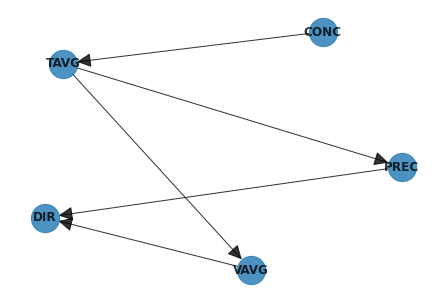

In [5]:
scoring_method = K2Score(data=pollen_data)
est = HillClimbSearch(data=pollen_data)
estimated_model = est.estimate(scoring_method=scoring_method, max_indegree=4, max_iter=int(1e4))

nx.draw(estimated_model, with_labels=True, arrowsize=30,
        node_size=800, alpha=0.8, font_weight='bold')
plt.show()


In [6]:
bayesian_model = BayesianModel(estimated_model.edges())
bayesian_model.fit(pollen_data, estimator=MaximumLikelihoodEstimator)
for cpd in bayesian_model.get_cpds():
    print(cpd)

+---------+----------+
| CONC(0) | 0.451632 |
+---------+----------+
| CONC(1) | 0.149581 |
+---------+----------+
| CONC(2) | 0.198672 |
+---------+----------+
| CONC(3) | 0.200116 |
+---------+----------+
+---------+----------------------+---------------------+----------------------+----------------------+
| CONC    | CONC(0)              | CONC(1)             | CONC(2)              | CONC(3)              |
+---------+----------------------+---------------------+----------------------+----------------------+
| TAVG(0) | 0.17710997442455242  | 0.03861003861003861 | 0.0377906976744186   | 0.03896103896103896  |
+---------+----------------------+---------------------+----------------------+----------------------+
| TAVG(1) | 0.1636828644501279   | 0.0637065637065637  | 0.040697674418604654 | 0.050505050505050504 |
+---------+----------------------+---------------------+----------------------+----------------------+
| TAVG(2) | 0.14130434782608695  | 0.11003861003861004 | 0.0465116279069

In [7]:
exact_inference = VariableElimination(bayesian_model)
print(exact_inference.query(["CONC"], evidence={'TAVG': 9}))

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]

+---------+-------------+
| CONC    |   phi(CONC) |
+=========+=============+
| CONC(0) |      0.2412 |
+---------+-------------+
| CONC(1) |      0.1794 |
+---------+-------------+
| CONC(2) |      0.3794 |
+---------+-------------+
| CONC(3) |      0.2000 |
+---------+-------------+


In [8]:
print(exact_inference.query(["CONC"], evidence={'TAVG': 2}))


0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]n Order: : : 0it [00:00, ?it/s]

+---------+-------------+
| CONC    |   phi(CONC) |
+=========+=============+
| CONC(0) |      0.6538 |
+---------+-------------+
| CONC(1) |      0.1686 |
+---------+-------------+
| CONC(2) |      0.0947 |
+---------+-------------+
| CONC(3) |      0.0828 |
+---------+-------------+


In [9]:
class Sampler:
    def __init__(self, bayesian_model):
        self.bayesian_model = bayesian_model
        self.sampler = BayesianModelSampling(bayesian_model)
        self.exact_inference = VariableElimination(bayesian_model)

    def run(self, evidence, query, min_samples=100, max_samples=10 ** 5, num_exp=20):
        test_range = range(min_samples, max_samples, int((max_samples - min_samples) / num_exp))
        errors_lws = []
        exact_result = self.exact_inference.query([query], dict(evidence), show_progress=False).values
        for size in test_range:
            lws_probs = self.process_lws(size, evidence, query)
            lws_error = self.absolute_error(lws_probs, exact_result)
            print(f"Experiment of size {size} achieved mean error {np.average(lws_error)}")
            errors_lws.append(lws_error)
        return list(test_range), errors_lws

    def process_lws(self, size, evidence, query):
        likelihood_sample = self.sampler.likelihood_weighted_sample(evidence=evidence, size=size)
        sample_probs = self.return_weighted_probs(likelihood_sample[query], likelihood_sample['_weight'])
        return sample_probs

    def absolute_error(self, sample_probs, exact_probs):
        absolute_error = np.fromiter(sample_probs.values(), dtype=float) - np.array(exact_probs)
        return absolute_error

    def return_probs(self, samples):
        unique, counts = np.unique(samples, return_counts=True)  # Get the unique values and their counts
        counts = (counts / len(samples))  # Divide the counts by the total number, getting a probability from 0 to 1
        return dict(zip(unique, counts))  # Zip the value and its probability in a dict

    def return_weighted_probs(self, samples, weights):
        unique = np.unique(samples)
        counts = np.zeros(len(np.unique(samples)))
        # We fill a zero array for the weights sum, the  we'll divide it by the sum of weights
        iterator = np.nditer(samples, flags=['f_index'])
        for value in iterator:
            counts[value] += weights[iterator.index]
        counts = (counts / np.sum(weights))
        return dict(zip(unique, counts))  # Zip the value and its probability in a dict


from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State

evidence = [State('TAVG', 8), State('VAVG', 2)]

sampler = Sampler(bayesian_model)
test_range, errors_lws = sampler.run(evidence, "CONC")


Generating for node: DIR: 100%|██████████| 5/5 [00:00<00:00, 121.14it/s]

Experiment of size 100 achieved mean error 2.0816681711721685e-17
Experiment of size 5095 achieved mean error -1.6445178552260131e-15
Experiment of size 10090 achieved mean error 4.003741782554471e-15



Generating for node: DIR:   0%|          | 0/5 [00:00<?, ?it/s] 

Experiment of size 15085 achieved mean error 6.779299344117362e-15
Experiment of size 20080 achieved mean error 7.93809462606987e-15


Generating for node: DIR: 100%|██████████| 5/5 [00:00<00:00, 37.31it/s] 

Experiment of size 25075 achieved mean error 2.6020852139652106e-15



Generating for node: DIR: 100%|██████████| 5/5 [00:00<00:00, 44.47it/s]

Experiment of size 30070 achieved mean error -8.049116928532385e-15



Generating for node: DIR: 100%|██████████| 5/5 [00:00<00:00, 35.89it/s] 

Experiment of size 35065 achieved mean error -1.8186840922140846e-14



Generating for node: DIR: 100%|██████████| 5/5 [00:00<00:00, 41.96it/s]

Experiment of size 40060 achieved mean error -2.4889812433315228e-14



Generating for node: DIR: 100%|██████████| 5/5 [00:00<00:00, 39.98it/s]

Experiment of size 45055 achieved mean error -3.042011087472929e-14



Generating for node: DIR: 100%|██████████| 5/5 [00:00<00:00, 44.14it/s]

Experiment of size 50050 achieved mean error -3.558264793923627e-14



Generating for node: DIR: 100%|██████████| 5/5 [00:00<00:00, 39.96it/s]

Experiment of size 55045 achieved mean error -3.8843928074072664e-14



Generating for node: DIR: 100%|██████████| 5/5 [00:00<00:00, 36.98it/s] 

Experiment of size 60040 achieved mean error -3.441691376337985e-14



Generating for node: DIR:  60%|██████    | 3/5 [00:00<00:00, 22.53it/s] 

Experiment of size 65035 achieved mean error -3.0829505615059816e-14


Generating for node: DIR: 100%|██████████| 5/5 [00:00<00:00, 32.10it/s] 

Experiment of size 70030 achieved mean error -2.9608260287972143e-14



Generating for node: VAVG:  40%|████      | 2/5 [00:00<00:00, 16.02it/s]

Experiment of size 75025 achieved mean error -2.7033930649622562e-14


Generating for node: DIR:  60%|██████    | 3/5 [00:00<00:00, 22.39it/s] 

Experiment of size 80020 achieved mean error -2.5181245977279332e-14


Generating for node: DIR: 100%|██████████| 5/5 [00:00<00:00, 26.98it/s] 

Experiment of size 85015 achieved mean error -2.2724877535296173e-14



Generating for node: DIR:  60%|██████    | 3/5 [00:00<00:00, 21.01it/s] 

Experiment of size 90010 achieved mean error -1.0901002323038256e-14


Generating for node: DIR: 100%|██████████| 5/5 [00:00<00:00, 22.24it/s]


Experiment of size 95005 achieved mean error 3.0322966360074588e-15


In [10]:
class Sampler:
    def __init__(self, bayesian_model, verbose=True):
        self.bayesian_model = bayesian_model
        self.sampler = BayesianModelSampling(bayesian_model)
        self.exact_inference = VariableElimination(bayesian_model)
        self.verbose = verbose
        self.precision = 2

    def prob_LW(self, samples, variable):
        return round(np.sum(np.dot(samples[variable], samples['_weight'])) /
                     np.sum(samples['_weight']), 2)

    def relative_error(self, exact_value, approx_value):
        return np.absolute((exact_value - approx_value) / exact_value)

    def absolute_error(self, exact_probs, sample_probs):
        absolute_error = np.fromiter(sample_probs.values(), dtype=float) - np.array(exact_probs)
        return absolute_error

    def run_experiment(self, query, evidence, sample_size):
        exact_result = self.exact_inference.query([query], dict(evidence), show_progress=False).values
        samples_LW = self.sampler.likelihood_weighted_sample(evidence=evidence,
                                                             size=sample_size)

        # Statistics
        pconc_LW = self.prob_LW(samples_LW, query)

        # Reporting
        if self.verbose:
            print("P(CONC | VAVG=2, TAVG=8) =", round(exact_result, self.precision))
            print("With Likelihood Weighting after %d samples: %.3f (error = %.2f percent)"
                  % (sample_size, pconc_LW, self.absolute_error(exact_result, pconc_LW) * 100))


evidence = [State('TAVG', 8), State('VAVG', 2)]
sampler = Sampler(bayesian_model)

starting_size_ = 1  # from 10 sample points
final_size = 5  # to 10^5 sample points
experiments = 20  # 8 experiments

for size in np.logspace(starting_size_, final_size, num=experiments, dtype='<i8'):
    sampler.run_experiment('CONC', evidence, sample_size=size)

Generating for node: DIR: 100%|██████████| 5/5 [00:00<00:00, 511.18it/s]


TypeError: type numpy.ndarray doesn't define __round__ method